# SAGE
---
01.pubmed
---
Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co
jariasg@uniquindio.edu.co

# Utils & Imports

In [1]:
# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv
import numpy as np



# Visualization
import networkx as nx
import matplotlib.pyplot as plt


# Dataset pubmed

In [3]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


## Node degrees

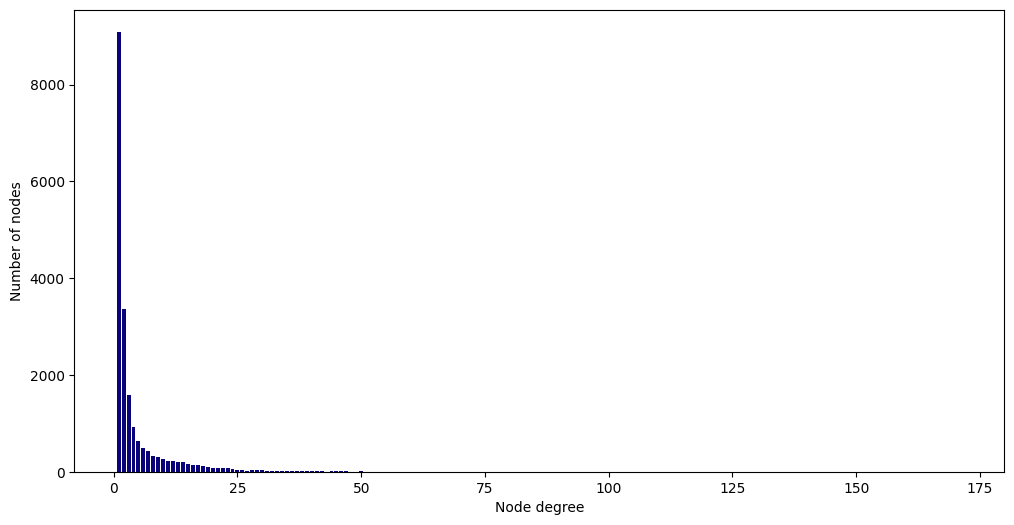

In [6]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)


# Model

In [53]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv


class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()

        self.conv = SAGEConv(dataset.num_features,
                             dataset.num_classes,
                             aggr="max") # max, mean, add ...)

    def forward(self):
        x = self.conv(data.x, data.edge_index)

        return F.log_softmax(x, dim=1)



# Train -Test

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')
model, data = GraphSAGE().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [55]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [56]:
best_val_acc = test_acc = 0
for epoch in range(1,100):
    model.train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'

    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

Epoch: 010, Val: 0.4040, Test: 0.4020
Epoch: 020, Val: 0.4040, Test: 0.4020
Epoch: 030, Val: 0.4040, Test: 0.4020
Epoch: 040, Val: 0.4040, Test: 0.4020
Epoch: 050, Val: 0.4040, Test: 0.4020
Epoch: 060, Val: 0.4040, Test: 0.4020
Epoch: 070, Val: 0.4040, Test: 0.4020
Epoch: 080, Val: 0.4040, Test: 0.4020
Epoch: 090, Val: 0.4040, Test: 0.4020
